# **Hourly Energy Prediction(MW) With Long-Short Term Memory**

---



In modern energy systems, understanding and predicting electricity consumption patterns is essential for efficient energy distribution, cost reduction, and grid stability.

The goal of this project is to predict hourly energy consumption (in megawatts) based on past usage data from the AEP (American Electric Power) region.

This is a time series forecasting problem, meaning the model must learn from patterns over time (like daily and seasonal cycles) to forecast future values.



Key Question:

Can we accurately forecast the next hour’s energy usage based on the previous 24 hours of data?

### Hourly Energy Dataset:

The Hourly Energy dataset is a collection of datasets of energy consumption on a hourly basis over a basis of 10 years. It is apart of the Eastern Connection Grid in the United States. It consists of:

> The data comes from PJM Interconnection, which manages the power grid for 13 U.S. states and Washington, D.C.

> PJM serves about 65 million people — that’s roughly 25 to 30 million homes, plus businesses, factories, and government buildings.

> So, while the dataset doesn’t show individual homes, each hourly value represents the total electricity used by millions of households and businesses combined.


>  Think of it like measuring how much power the entire East Coast region is using every single hour.

The Data set is a system-wide rather than apart of a individual household or building level. So there is no breakdown to these readings that we have.

> That means you might have to handle missing data or non-uniform coverage across time.

Using aggregate data means you may miss fine-grained features (e.g., appliance-level usage, event-level switching) — your forecasting or analysis will be at the macro level.

When applying ML models, you should consider the temporal autocorrelation, seasonality, trends, and possibly non-stationarity (i.e., statistical properties might change over time).

**Here are the current libraries used to bring this this dataset to life:**

1. **os, datetime** → handle file paths and date/time data.

2. **matplotlib.pyplot & seaborn** → make graphs to visualize data.

3. **numpy** → handle numerical operations (arrays, reshaping, etc.).

4. **pandas** → load and manipulate data (like spreadsheets).

5. **tensorflow / keras** → build and run the neural network.

6. **sklearn.preprocessing.MinMaxScaler** → normalize (rescale) your data.

7. **sklearn.metrics** → compute accuracy/error numbers.

8. **matplotlib.image** → for image-related plots (not essential here but useful).

In [36]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
import urllib.request
import time
from sklearn.metrics import mean_absolute_percentage_error


Load the CSV file into a pandas DataFrame.

The first column was unnamed, so we rename it to "Datetime".

Convert that column to datetime objects so pandas recognizes the timestamps.

Make the datetime column the index — that helps with plotting and time-based analysis.

In [ ]:
def load_data(data_url=None):
    if data_url:
        try:
            print(f"\n📥 Loading from URL: {data_url}")
            df = pd.read_csv(data_url)
            print(f"✓ Loaded {len(df)} records from URL")
            return df
        except Exception as e:
            print(f"⚠ Could not load from URL: {e}")

    try:
        print("\n📁 Loading local file: AEP_hourly.csv")
        df = pd.read_csv('AEP_hourly.csv')
        print(f"✓ Loaded {len(df)} records")
        return df
    except FileNotFoundError:
        print("⚠ File not found. Creating dummy data...")
        dates = pd.date_range(start='2004-12-31', periods=10000, freq='h')
        values = 15000 + 3000 * np.sin(np.linspace(0, 100, 10000)) + np.random.randn(10000) * 500
        df = pd.DataFrame({'Datetime': dates, 'AEP_MW': values})
        print(f"✓ Created {len(df)} dummy records")
        return df

DATA_URL = "https://raw.githubusercontent.com/Trellises/LTClass-Code/refs/heads/main/AEP_hourly.csv"
df = load_data(DATA_URL)


📥 Loading from URL: https://raw.githubusercontent.com/Trellises/LTClass-Code/refs/heads/main/AEP_hourly.csv
✓ Loaded 121273 records from URL


File Used: AEP_hourly.csv
Source: PJM Interconnection (real-world public energy data).
Feature Used: AEP_MW (energy consumption in megawatts).

The dataset records hourly energy usage over multiple years.

The first column contains timestamps (renamed to Datetime).

After cleaning, the dataset looks like this:

In [ ]:
if 'Datetime' in df.columns or 'Unnamed: 0' in df.columns:
    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

print(f"\n✓ Data shape: {df.shape}")
print(f"✓ Energy range: {df['AEP_MW'].min():.2f} to {df['AEP_MW'].max():.2f} MW")


✓ Data shape: (121273, 1)
✓ Energy range: 9581.00 to 25695.00 MW


**Below is code for the training of the model:**

In [ ]:
n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

What is the goal here?

When we build a machine learning model, we don’t train and evaluate on the same data.
Instead, we split the dataset into three parts:

Training data – used to teach the model

Validation data – used to tune and check the model while building it

Test data – used at the very end to evaluate final performance

Therefore we calculate 70% of the dataset giving the first 70% of the dataset


*   At n * 0.7 the training dataset stops and begins the Validation data
*   The validation data between the 0.7 and 0.9
*   With the last 0.10 (10%) as test data





In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

Line 1: scaler = MinMaxScaler() - Creates a scaler tool
Line 2: train_scaled = scaler.fit_transform(train_df)

Learns min/max from training data (e.g., 9,346-25,672 MW)
Scales values to 0-1 using: (value - min) / (max - min)

Line 3: val_scaled = scaler.transform(val_df)

Scales validation using training's min/max (doesn't learn new values)

Line 4: test_scaled = scaler.transform(test_df)

Scales test using training's min/max (doesn't learn new values)

Why? Neural networks train better with small numbers (0-1) than large numbers (9,000-25,000 MW).
Key Rule: Only fit_transform() on training; use transform() on validation/test.

In [ ]:
sequence_length = 7
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

The function creates:

X = [15,000, 15,500, 16,000, 15,800, 15,200, 14,900, 15,100] (7 hours)
y = 15,400 (next hour to predict)

Why?
Time series data has patterns over time. By looking at the past 7 hours, the model can learn:

Daily patterns (morning vs evening)
Trends (increasing or decreasing)
Recent context (what just happened)

Then it uses this to predict what happens next!
Result:

X_train = thousands of 7-hour sequences from training data
y_train = the actual next hour for each sequence
Same for validation and test sets

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

The Dense neural network (fully connected layers) expects flat input, not 3D sequences.

Dense layers need: [value1, value2, value3, ...]
Not: [[value1], [value2], [value3], ...]

What -1 Means:
reshape(X_train.shape[0], -1) means:

Keep the same number of samples (X_train.shape[0])
Flatten everything else (-1 = "figure it out automatically")

It's like unrolling a column of numbers into a single row!

In [ ]:
MODEL_URL = "https://github.com/Trellises/LTClass-Code/raw/refs/heads/main/my_energy_model.h5"

try:
    print("\n📥 Downloading Dense model from GitHub...")
    urllib.request.urlretrieve(MODEL_URL, 'dense_energy_model.h5')
    print("✓ Model downloaded")

    # Load model WITHOUT compiling (avoids the 'mse' function issue)
    model = tf.keras.models.load_model('dense_energy_model.h5', compile=False)

    # Compile with actual function objects, not strings
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    print("✓ Model loaded and ready!")

except Exception as e:
    print(f"⚠ Could not load model: {e}")
    print("🔄 Training new model instead...\n")

    # Build the Dense model
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    # Compile with actual function objects
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=512
    )

    # Save the trained model
    model.save('dense_energy_model.h5')
    print("\n✓ Model trained and saved as 'dense_energy_model.h5'")
    print("📤 Upload this file to GitHub to skip training next time!")


📥 Downloading Dense model from GitHub...
✓ Model downloaded
✓ Model loaded and ready!


In [ ]:
print("📊 STEP 5: Testing Model...")

y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mape = mean_absolute_percentage_error(y_test_unscaled, y_pred) * 100

print("\n" + "="*75)
print("                        🎯 RESULTS")
print("="*75)
print(f"  Accuracy (MAPE):  {mape:.2f}% error")
print(f"  Training time:    {time.time() - start_time:.1f} seconds")
print(f"  Samples used:     {len(df):,}")
print("="*75)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Line 1: model.predict(X_test)

Model makes predictions on test data
Results are scaled (0 to 1)
Example: [0.523, 0.687, 0.342]

Line 2: scaler.inverse_transform(y_pred_scaled)

Converts predictions back to MW
Example: [0.523, 0.687, 0.342] → [15,823 MW, 19,456 MW, 12,943 MW]

Line 3: scaler.inverse_transform(y_test)

Converts actual test values back to MW
Now we can compare predictions vs actual in real units

Why? The model learned on scaled data (0-1), so it predicts in scaled values. We convert back to MW so humans can understand: "Predicted 15,823 MW" is clearer than "Predicted 0.523"!
reshape(-1, 1) converts to column format that the scaler needs.Predicti

In [ ]:
start, end = 10000, 12000

for i in range(start, end):
    print(f"Timestep {i}: Actual = {y_test_unscaled[i][0]}, Predicted = {y_pred[i][0]}")

Timestep 10000: Actual = 13636.0, Predicted = 13315.634765625
Timestep 10001: Actual = 13315.0, Predicted = 13202.4228515625
Timestep 10002: Actual = 13123.0, Predicted = 13012.2802734375
Timestep 10003: Actual = 13038.0, Predicted = 12777.3232421875
Timestep 10004: Actual = 13005.0, Predicted = 12563.623046875
Timestep 10005: Actual = 13186.0, Predicted = 12421.4013671875
Timestep 10006: Actual = 13956.0, Predicted = 12365.3505859375
Timestep 10007: Actual = 13895.0, Predicted = 12525.859375
Timestep 10008: Actual = 13621.0, Predicted = 12656.8388671875
Timestep 10009: Actual = 13111.0, Predicted = 12774.6494140625
Timestep 10010: Actual = 12304.0, Predicted = 12714.1455078125
Timestep 10011: Actual = 12014.0, Predicted = 12276.3193359375
Timestep 10012: Actual = 11757.0, Predicted = 11932.3779296875
Timestep 10013: Actual = 11675.0, Predicted = 11628.5537109375
Timestep 10014: Actual = 12011.0, Predicted = 11376.8359375
Timestep 10015: Actual = 12780.0, Predicted = 11294.744140625
Ti

Line 1: start, end = 10000, 12000

Sets the range to look at timesteps 10,000 through 12,000
That's 2,000 predictions to print

Lines 2-3: Loop through and print each prediction

For each timestep, prints the actual value vs predicted value
Shows how close the model's predictions are to reality
Why?
This lets you see individual predictions to check:

Is the model predicting too high or too low?
Are there specific times when predictions are bad?
How well does the model track the actual values?

What [i][0] Means:

[i] = get the i-th prediction/actual value
[0] = extract the number from the array format [[15234.5]] → 15234.5

Note:
Printing 2,000 lines will be a LOT of output! This is mainly useful for debugging or checking specific time periods.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error


mape = mean_absolute_percentage_error(y_test_unscaled, y_pred) * 100
mse = mean_squared_error(y_test_unscaled, y_pred)
mae = mean_absolute_error(y_test_unscaled, y_pred)


In [ ]:
print("\n" + "="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Squared Error (MSE):              {mse:.2f}")
print(f"Mean Absolute Error (MAE):             {mae:.2f} MW")
print("="*50 + "\n")



MODEL EVALUATION METRICS
Mean Absolute Percentage Error (MAPE): 9.28%
Mean Squared Error (MSE):              3240914.27
Mean Absolute Error (MAE):             1441.46 MW



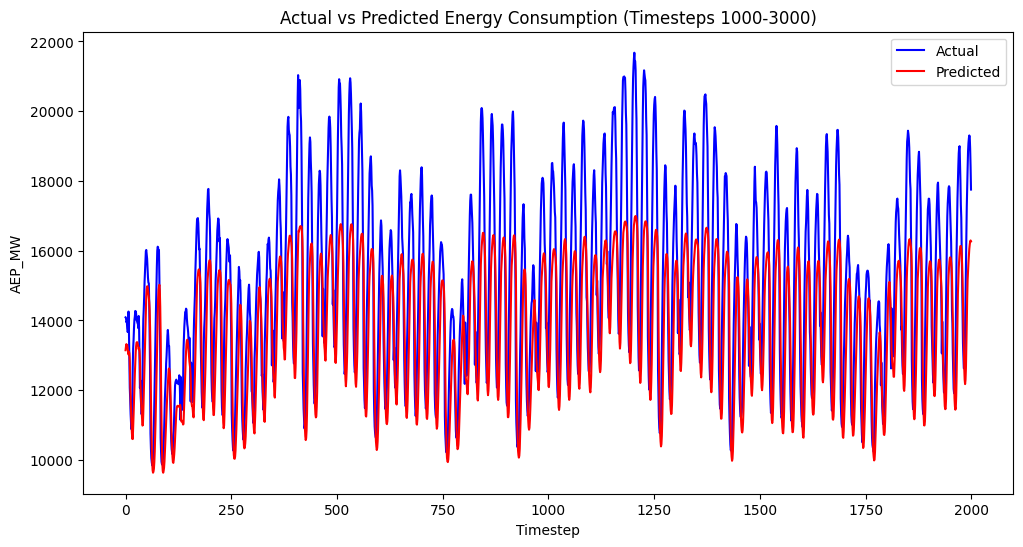

In [ ]:
# Plot subset
start = 1000
end = 3000
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[start:end], label='Actual', color='blue')
plt.plot(y_pred[start:end], label='Predicted', color='red')
plt.xlabel('Timestep')
plt.ylabel('AEP_MW')
plt.title(f'Actual vs Predicted Energy Consumption (Timesteps {start}-{end})')
plt.legend()
plt.show()

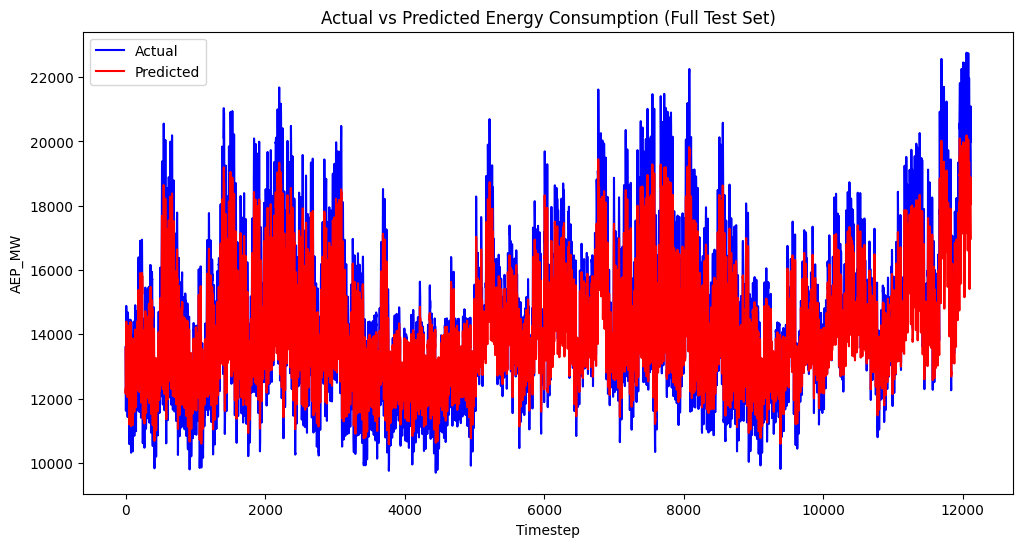

In [ ]:
# Plot all test data
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Timestep')
plt.ylabel('AEP_MW')
plt.title('Actual vs Predicted Energy Consumption (Full Test Set)')
plt.legend()
plt.show()

 #  **Smaller Portion of the Data Set:**

In [20]:
print("\n" + "="*75)
print("        🚀 FAST ENERGY PREDICTION DEMO - WATCH IT LEARN!")
print("="*75)
print("⏱️  Training time: ~20 seconds | 🎓 Perfect for classroom demos")
print("="*75 + "\n")

start_time = time.time()


        🚀 FAST ENERGY PREDICTION DEMO - WATCH IT LEARN!
⏱️  Training time: ~20 seconds | 🎓 Perfect for classroom demos



In [21]:
print("📁 STEP 1: Loading Energy Data...")

DATA_URL = "https://raw.githubusercontent.com/Trellises/LTClass-Code/refs/heads/main/AEP_hourly.csv"

try:
    df = pd.read_csv(DATA_URL)
    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
    print(f"✓ Loaded {len(df):,} hourly records from PJM grid")
except:
    dates = pd.date_range(start='2004-12-31', periods=5000, freq='h')
    values = 15000 + 3000 * np.sin(np.linspace(0, 100, 5000)) + np.random.randn(5000) * 500
    df = pd.DataFrame({'Datetime': dates, 'AEP_MW': values})
    print("✓ Created sample data for demo")

# Use only 2000 samples for FAST training
df = df[:2000].copy()
print(f"📊 Using {len(df):,} samples (faster demo)")
print(f"⚡ Energy range: {df['AEP_MW'].min():.0f} - {df['AEP_MW'].max():.0f} MW\n")

📁 STEP 1: Loading Energy Data...
✓ Loaded 121,273 hourly records from PJM grid
📊 Using 2,000 samples (faster demo)
⚡ Energy range: 10263 - 22577 MW



In [26]:
print("✂️  STEP 2: Preparing Data...")

n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


✂️  STEP 2: Preparing Data...


In [27]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['AEP_MW']])
val_scaled = scaler.transform(val_df[['AEP_MW']])
test_scaled = scaler.transform(test_df[['AEP_MW']])

sequence_length = 7
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f"✓ Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}\n")

✓ Train: 1393 | Val: 393 | Test: 193



In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("✓ Network: 32 → 16 → 1 (simple & fast!)\n")


✓ Network: 32 → 16 → 1 (simple & fast!)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
print("🚀 STEP 4: TRAINING MODEL - WATCH IT LEARN!")
print("="*75)
print(" Epoch  |  Train Loss  |  Val Loss   |  Status")
print("-"*75)

🚀 STEP 4: TRAINING MODEL - WATCH IT LEARN!
 Epoch  |  Train Loss  |  Val Loss   |  Status
---------------------------------------------------------------------------


In [30]:
class SimpleProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs['loss']
        val_loss = logs['val_loss']

        if epoch == 0:
            status = "🌱 Starting"
        elif val_loss < self.best_val:
            status = "✓ Improving!"
            self.best_val = val_loss
        else:
            status = "→ Learning"

        print(f"   {epoch+1:2d}    |   {train_loss:.6f}   |  {val_loss:.6f}  | {status}")

    def on_train_begin(self, logs=None):
        self.best_val = float('inf')

# Train for only 10 epochs - very fast!
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=0,
    callbacks=[SimpleProgress()]
)

    1    |   0.073157   |  0.012012  | 🌱 Starting
    2    |   0.013051   |  0.013493  | ✓ Improving!
    3    |   0.010343   |  0.008766  | ✓ Improving!
    4    |   0.007504   |  0.005985  | ✓ Improving!
    5    |   0.005135   |  0.004364  | ✓ Improving!
    6    |   0.004121   |  0.004092  | ✓ Improving!
    7    |   0.003506   |  0.003631  | ✓ Improving!
    8    |   0.003047   |  0.003126  | ✓ Improving!
    9    |   0.002708   |  0.002321  | ✓ Improving!
   10    |   0.002419   |  0.002198  | ✓ Improving!


In [38]:
print("📊 STEP 5: Testing Model...")

y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = np.mean((y_test_unscaled - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))

print("\n" + "="*75)
print("                        🎯 RESULTS")
print("="*75)
print(f"  MAPE (% Error):              {mape:.2f}%")
print(f"  RMSE (Root Mean Sq Error):   {rmse:.2f} MW")
print(f"  MAE (Mean Absolute Error):   {mae:.2f} MW")
print(f"  MSE (Mean Squared Error):    {mse:.2f}")
print(f"  Training time:               {time.time() - start_time:.1f} seconds")
print(f"  Samples used:                {len(df):,}")
print("="*75)



📊 STEP 5: Testing Model...

                        🎯 RESULTS
  MAPE (% Error):              3.28%
  RMSE (Root Mean Sq Error):   558.51 MW
  MAE (Mean Absolute Error):   434.33 MW
  MSE (Mean Squared Error):    311932.83
  Training time:               1313.0 seconds
  Samples used:                2,000
